In [1]:
%matplotlib inline
import os, sys, gc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import gridspec
import matplotlib.image as mpimg

from scipy.stats import pearsonr 
from scipy.stats import spearmanr 

In [2]:
def around(mat, dp = 3):
    return np.around(mat, dp)
np.random.seed(0)

potentialPermIdx =  np.arange(10000)
print('potential perm idx: {0}'.format(potentialPermIdx[:5]))
np.random.shuffle(potentialPermIdx)
print('potential perm idx: {0}'.format(potentialPermIdx[:5]))
gtLabels = np.squeeze(np.int_(np.load('test_set_cifar_labels.npy')))
reorderedGT = gtLabels[potentialPermIdx]

loadDir = 'preds_scores_9k'
#print(os.listdir(loadDir))
model = 'shake_shake_26_2x64d_SSI_cutout16'

imNames = np.load('decoded_test_filename_order.npy')[potentialPermIdx]
print(imNames[:5])
control = np.load('{0}/{1}_True.npz'.format(loadDir, model))
controlTop = np.argmax(control['probs'], axis = 1)
controlLabels = np.argmax(control['labels'], axis = 1)
controlLabelsHard = np.argmax(control['hard_labels'], axis = 1)
actual = np.load('{0}/{1}_False.npz'.format(loadDir, model))
actualTop = np.argmax(actual['probs'], axis = 1)
actualLabels = np.argmax(actual['labels'], axis = 1)
actualLabelsHard = np.argmax(actual['hard_labels'], axis = 1)
humans = np.load('human_bincounts.npy')
humans = humans / np.sum(humans, axis = 1)[:, np.newaxis]
humanTop = np.argmax(humans, axis = 1)

potential perm idx: [0 1 2 3 4]
potential perm idx: [9394  898 2398 5906 2343]
['canis_familiaris_s_000381.png' 'tabby_s_001247.png'
 'dredger_s_001602.png' 'elk_s_001174.png' 'grass_frog_s_000780.png']


print(list(control.keys()))

print(around(control['labels'][:5]), '\n', around(humans[:5]), '\n',
     around(actual['labels'][:5]))

print(controlLabels[:5], '\n', humanTop[:5], '\n',
     actualLabels[:5])

print(humanTop[:5], '\n',
     gtLabels[:5])

print(controlLabels[:5], '\n', controlLabelsHard[:5], '\n',
     actualLabels[:5], '\n', actualLabelsHard[:5],
      '\n', gtLabels[potentialPermIdx][:5], '\n',
     humanTop[potentialPermIdx][:5])

In [3]:
wrongIdxCon = np.where(controlTop != reorderedGT)[0]
correctIdxCon = np.where(controlTop == reorderedGT)[0]
wrongIdxAct = np.where(actualTop != reorderedGT)[0]
correctIdxAct = np.where(actualTop == reorderedGT)[0]

keys = ['control_soft_labels', 'control_hard_labels', 'control_wrong_hard', 'control_correct_hard',
       'actual_soft_labels', 'actual_hard_labels', 'actual_wrong_hard', 'actual_correct_hard']
candidates = [controlTop, controlTop, controlTop[wrongIdxCon], controlTop[correctIdxCon],
             actualTop, actualTop, actualTop[wrongIdxAct], actualTop[correctIdxAct]]
labels = [controlLabels, controlLabelsHard, controlLabelsHard[wrongIdxCon], controlLabelsHard[correctIdxCon],
         actualLabels, actualLabelsHard, actualLabelsHard[wrongIdxAct], actualLabelsHard[correctIdxAct]]

corrDict = {}
for k, c, l in zip(keys, candidates, labels):
    print(k)
    corrDict[k] = pearsonr(c, l)[0]



print(corrDict)

control_soft_labels
control_hard_labels
control_wrong_hard
control_correct_hard
actual_soft_labels
actual_hard_labels
actual_wrong_hard
actual_correct_hard
{'control_soft_labels': 0.8746086487506933, 'control_hard_labels': 0.8720925631026378, 'control_wrong_hard': -0.3300961985269418, 'control_correct_hard': 1.0, 'actual_soft_labels': 0.8913918331742259, 'actual_hard_labels': 0.8889240382158908, 'actual_wrong_hard': -0.31655004952852195, 'actual_correct_hard': 1.0}


In [4]:
wrongConCon = np.mean(np.max(control['probs'][wrongIdxCon], axis = 1))
correctConCon = np.mean(np.max(control['probs'][correctIdxCon], axis = 1))
wrongActCon = np.mean(np.max(actual['probs'][wrongIdxAct], axis = 1))
correctActCon = np.mean(np.max(actual['probs'][correctIdxAct], axis = 1))

[0.95962644, 0.935319] [0.7656197, 0.6850956]


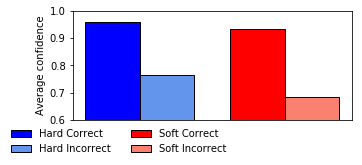

In [59]:
def fig_fn(dataSeries1, dataSeries2, savePath):
    # set width of bar
    barWidth = 0.25

    # set height of bar
    print(dataSeries1, dataSeries2)
    # Set position of bar on X axis
    r1 = np.arange(len(dataSeries1))/1.5
    r2 = [x + barWidth for x in r1]
    plt.figure(figsize = (5, 2))
    # Make the plot
    plt.bar(r1, dataSeries1, color=['blue', 'red'], width=barWidth, edgecolor='k', label='Correct images')
    plt.bar(r2, dataSeries2, color=['cornflowerblue', 'salmon'], width=barWidth, edgecolor='k', label='Incorrect images')
    plt.ylabel('Average confidence')
    #plt.xlabel('Condition')
    plt.ylim([0.6, 1.0])
    # Add xticks'Condition on the middle of the group bars
    #plt.xticks([r + barWidth/2 for r in r1], ['Hard', 'Soft'])
    plt.xticks([])
    legend_elements = [
                Patch(facecolor='blue', edgecolor='k',
                         label='Hard Correct'),
        Patch(facecolor='cornflowerblue', edgecolor='k',
                         label='Hard Incorrect'),
                   Patch(facecolor='red', edgecolor='k',
                         label='Soft Correct'),
        Patch(facecolor='salmon', edgecolor='k',
                         label='Soft Incorrect')

    ]
    # Create legend & Show graphic
    lgd = plt.legend(handles=legend_elements, ncol = 2, bbox_to_anchor=(0.58285, 0.0), 
              frameon = False)
    if savePath:
        plt.savefig(savePath, bbox_inches = 'tight', bbox_extra_artists=(lgd,))
    plt.show()
fig_fn([correctConCon, correctActCon], [wrongConCon,  wrongActCon],
       '/Users/ruairidh/Academic/Berkeley/superman/cifar10-human-experiments/figures/rebuttal_confidences.pdf')

(0.09515962590596257, 2.90372124922144e-26) (0.14659250227816314, 1.6708443002781362e-55)


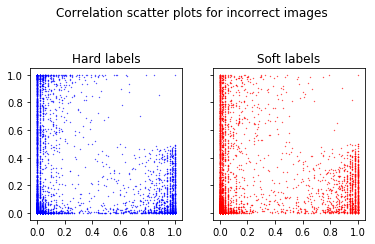

In [27]:
s = 0.1
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex=True, sharey=True)
fig.suptitle('Correlation scatter plots for incorrect images')
ax[0].scatter(humans[potentialPermIdx][wrongIdxCon].ravel(), control['probs'][wrongIdxCon].ravel(), s = s, c = 'b')
ax[0].set(adjustable='box-forced', aspect='equal')
ax[0].set_title('Hard labels')
ax[0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[1].scatter(humans[potentialPermIdx][wrongIdxAct].ravel(), actual['probs'][wrongIdxAct].ravel(), s = s, c = 'r')
ax[1].set(adjustable='box-forced', aspect='equal')
ax[1].set_title('Soft labels')

print(pearsonr(humans[potentialPermIdx][wrongIdxCon].ravel(), control['probs'][wrongIdxCon].ravel()), 
      pearsonr(humans[potentialPermIdx][wrongIdxAct].ravel(), actual['probs'][wrongIdxAct].ravel()))

In [7]:
def spearman_fn(base, test):
    """base and test are each samples by classes"""
    numSamples = base.shape[0]
    spearmanrs = np.empty(numSamples)
    print(base.shape, test.shape)
    for i in np.arange(numSamples):
        spearmanrs[i] = spearmanr(base[i, :], test[i, :])[0]
        
    return spearmanrs

def pearson_fn(base, test):
    """base and test are each samples by classes"""
    numSamples = base.shape[0]
    pearsonrs = np.empty(numSamples)
    print(base.shape, test.shape)
    for i in np.arange(numSamples):
        pearsonrs[i] = pearsonr(base[i, :], test[i, :])[0]
        
    return pearsonrs


actualSpearmans = spearman_fn(actual['probs'], actual['labels'])
controlSpearmans = spearman_fn(control['probs'], control['labels'])

actualPearson = pearson_fn(actual['probs'], actual['labels'])
controlPearson= pearson_fn(control['probs'], control['labels'])
print(actualSpearmans.mean(), actualSpearmans[:5], '\n', 
     controlSpearmans.mean(), controlSpearmans[:5])

differenceS = actualSpearmans - controlSpearmans
differenceP = actualPearson - controlPearson
indexArray = np.array([0, 1, 3, 9, 12])
candidates = np.argsort(differenceS)[::-1][:50][indexArray]
#print(candidates)
ims = [imNames[x] for x in candidates]
print(ims)
modelNames = ['human', 'soft', 'hard']
candDict = {'human': {'probs': humans[potentialPermIdx]},
           'soft': {'probs': actual['probs']},
           'hard': {'probs': control['probs']}}

for m in modelNames:
    for i in candidates:
        candDict[m][i] = candDict[m]['probs'][i, :]

(10000, 10) (10000, 10)
(10000, 10) (10000, 10)
(10000, 10) (10000, 10)
(10000, 10) (10000, 10)
0.5521248561945173 [0.52223297 0.66364341 0.26967994 0.52223297 0.52223297] 
 0.53801254409423 [0.52223297 0.23115669 0.60677988 0.52223297 0.52223297]


num models:  3
num images:  5


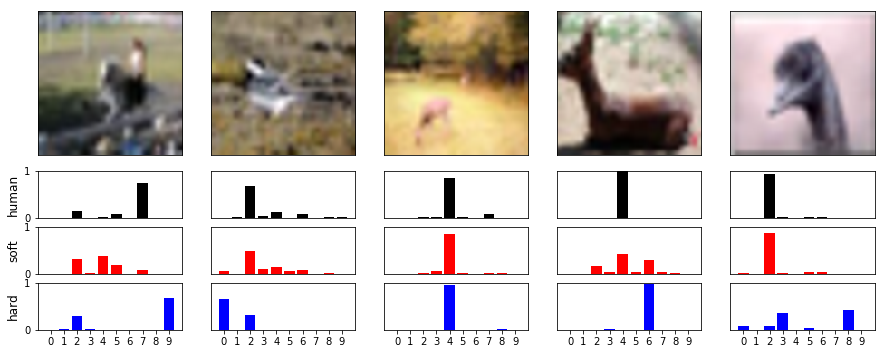

In [34]:
def fig_fn(imNums, imNames, models, modelNames, im_dir, save_path):
    """still a bunch of other things defined above
    that aren't in here"""

    numModels = len(modelNames)
    numIms = len(imNums)
    print('num models: ', numModels)
    print('num images: ', numIms)
    
    fig = plt.figure(figsize = (numIms*3, numModels+3)) 
    gs = gridspec.GridSpec(numModels + 3, numIms)
    colors = ['black', 'red', 'blue']
    for i in np.arange(numIms):
        im = imNames[i]
        imNum = imNums[i]
        ax_im_b = plt.subplot(gs[: 3, i]) # size of im
        im_name_b = str(im)
        ax_im_b.xaxis.set_ticklabels([])
        ax_im_b.set_xticks([])
        ax_im_b.set_yticks([])
        #ax_im_b.set_title(labels[0], fontsize = 12)
        ax_im_b.yaxis.set_ticklabels([])
        img_b = mpimg.imread(im_dir + '/' + im_name_b)
        #ax_im_b.set_title('High certainty image', fontsize = 20)
        ax_im_b.imshow(img_b)

        for m, model in enumerate(modelNames):
            im_guesses = models[model][imNum]
            #print(im_guesses)
            ax = plt.subplot(gs[3 + m, i])
            ax.bar(np.arange(10), im_guesses, color = colors[m]) #, align = 'left')
            ax.set_xlim([-1, 10])
            ax.set_ylim([0, 1]) 

            if ax.is_first_col():
                ax.set_yticks([0, 1])
                ax.set_ylabel(model[:5], fontsize = 12)
            else:
                ax.yaxis.set_ticks([])

            ax.xaxis.set_ticks([])

            if ax.is_last_row():
                ax.xaxis.set_ticks(np.arange(10))
            #    ax.xaxis.set_ticklabels(labels)
            #    plt.xticks(rotation = -45, ha='center')
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
fig_fn(candidates, ims, candDict, modelNames, 
       '/Users/ruairidh/Academic/Berkeley/superman/images/test_images_named', 
       '/Users/ruairidh/Academic/Berkeley/superman/cifar10-human-experiments/figures/rebuttal_example_ims.pdf')   